In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore, norm
from sklearn.metrics.pairwise import cosine_similarity
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

def generate_player_profile(player_name, position_group):
    """
    Generates a player profile visualization based on their position group.

    Args:
        player_name (str): The full name of the player to profile.
        position_group (str): The group of positions to analyze.
                               Valid options: 'Centre-back', 'Full-back', 'Midfielder',
                               'Attacking Midfielder', 'Attacker'.
    """
    # ---------------- 1. LOAD DATA ----------------
    try:
        file_path = "/Users/user/Downloads/2025-2026 DB/Norway.xlsx"
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: The file was not found at {file_path}")
        return

    df.rename(columns={"Nationality": "Passport country"}, inplace=True)

    # ---------------- 2. DEFINE POSITIONAL GROUPS, CATEGORIES, AND ROLES ----------------
    if position_group == 'Centre-back':
        positions = ['CB', 'RCB', 'LCB']
        categories = {
            "Security": ["Accurate passes, %", "Back passes per 90", "Accurate back passes, %", "Lateral passes per 90", "Accurate lateral passes, %"],
            "Progressive Passing": ["Progressive passes per 90", "Accurate progressive passes, %", "Forward passes per 90", "Accurate forward passes, %", "Passes to final third per 90", "Accurate passes to final third, %"],
            "Ball Carrying": ["Progressive runs per 90", "Dribbles per 90", "Successful dribbles, %", "Accelerations per 90"],
            "Creativity": ["Key passes per 90", "Shot assists per 90", "xA per 90", "Smart passes per 90", "Accurate smart passes, %"],
            "Proactive Defending": ["Interceptions per 90", "PAdj Interceptions", "Sliding tackles per 90", "PAdj Sliding tackles"],
            "Duelling": ["Duels per 90", "Duels won, %", "Aerial duels per 90", "Aerial duels won, %"],
            "Box Defending": ["Shots blocked per 90"],
            "Sweeping": []
        }
        roles = {
            "Ball Player": ["Progressive Passing", "Security"], "Libero": ["Progressive Passing", "Ball Carrying", "Creativity"],
            "Wide Creator": ["Creativity", "Ball Carrying"], "Aggressor": ["Proactive Defending", "Duelling"],
            "Physical Dominator": ["Duelling", "Box Defending"], "Box Defender": ["Box Defending", "Duelling"]
        }

    elif position_group == 'Full-back':
        positions = ['LB', 'RB', 'LWB', 'RWB']
        categories = {
            "Box Defending": ["Shots blocked per 90"],
            "Duelling": ["Duels per 90", "Duels won, %", "Aerial duels per 90", "Aerial duels won, %", "Defensive duels per 90", "Defensive duels won, %"],
            "Pressing": ["PAdj Interceptions", "PAdj Sliding tackles", "Counterpressing recoveries per 90"],
            "Security": ["Accurate passes, %", "Back passes per 90", "Accurate back passes, %", "Lateral passes per 90", "Accurate lateral passes, %"],
            "Playmaking": ["Key passes per 90", "Shot assists per 90", "xA per 90", "Smart passes per 90", "Accurate smart passes, %"],
            "Final Third": ["Passes to final third per 90", "Accurate passes to final third, %", "Crosses per 90", "Accurate crosses, %", "Touches in box per 90"],
            "Overlapping": ["Accelerations per 90", "Fouls suffered per 90"],
            "Ball Carrying": ["Progressive runs per 90", "Dribbles per 90", "Successful dribbles, %"]
        }
        roles = {
            "False Wing": ["Playmaking", "Ball Carrying", "Final Third"], "Flyer": ["Overlapping", "Final Third", "Ball Carrying"],
            "Playmaker": ["Playmaking", "Security", "Final Third"], "Safety": ["Security", "Box Defending", "Pressing"],
            "Ballwinner": ["Duelling", "Pressing"], "Defensive FB": ["Box Defending", "Duelling", "Pressing"]
        }

    elif position_group == 'Midfielder':
        positions = ['LCMF', 'RCMF', 'CFM', 'LDMF', 'RDMF', 'RAMF', 'LAMF', 'AMF', 'DMF']
        categories = {
            "Creativity": ["Key passes per 90", "Shot assists per 90", "xA per 90", "Smart passes per 90", "Accurate smart passes, %"],
            "Box Crashing": ["Touches in box per 90", "Shots per 90", "xG per 90", "Non-penalty goals per 90"],
            "Ball Carrying": ["Progressive runs per 90", "Dribbles per 90", "Successful dribbles, %", "Accelerations per 90"],
            "Progressive Passing": ["Progressive passes per 90", "Accurate progressive passes, %", "Passes to final third per 90", "Accurate passes to final third, %"],
            "Dictating": ["Passes per 90", "Accurate passes, %", "Forward passes per 90", "Accurate forward passes, %", "Lateral passes per 90"],
            "Ball Winning": ["PAdj Interceptions", "Counterpressing recoveries per 90", "Defensive duels won, %"],
            "Destroying": ["Duels per 90", "Defensive duels per 90", "PAdj Sliding tackles", "Fouls per 90"]
        }
        roles = {
            "Anchor": ["Destroying", "Ball Winning", "Dictating"], "DLP": ["Dictating", "Progressive Passing", "Creativity"],
            "Ball Winner": ["Ball Winning", "Destroying"], "Box to Box": ["Progressive Passing", "Ball Carrying", "Box Crashing", "Ball Winning"],
            "Box Crasher": ["Box Crashing", "Ball Carrying", "Creativity"], "Playmaker": ["Creativity", "Progressive Passing", "Dictating"],
            "Attacking mid": ["Creativity", "Box Crashing", "Progressive Passing"]
        }

    elif position_group == 'Attacking Midfielder':
        positions = ['AMF', 'RAMF', 'LAMF', 'LW', 'RW']
        categories = {
            "Pressing": ["Counterpressing recoveries per 90", "PAdj Interceptions", "Defensive duels per 90"],
            "Build up": ["Passes per 90", "Accurate passes, %", "Progressive passes per 90"],
            "Final ball": ["Key passes per 90", "xA per 90", "Deep completions per 90"],
            "Wide creation": ["Crosses per 90", "Accurate crosses, %", "Passes to penalty area per 90"],
            "Movement": ["Accelerations per 90", "Touches in box per 90"],
            "Ball Carrying": ["Progressive runs per 90", "Dribbles per 90"],
            "1v1 ability": ["Dribbles per 90", "Successful dribbles, %", "Fouls suffered per 90"],
            "Box presence": ["Touches in box per 90", "xG per 90", "Shots per 90"],
            "Finishing": ["Non-penalty goals per 90", "xG per 90", "Shots on target, %"]
        }
        roles = {
            "Winger": ["Wide creation", "1v1 ability", "Ball Carrying"], "Direct Dribbler": ["1v1 ability", "Ball Carrying", "Movement"],
            "Industrious Winger": ["Pressing", "Ball Carrying", "Wide creation"], "Shadow Striker": ["Box presence", "Finishing", "Movement"],
            "Wide playmaker": ["Wide creation", "Final ball", "Build up"], "Playmaker": ["Final ball", "Build up", "1v1 ability"]
        }

    elif position_group == 'Attacker':
        positions = ['CF', 'LW', 'RW']
        categories = {
            "Pressing": ["Counterpressing recoveries per 90", "PAdj Interceptions", "Defensive duels per 90"],
            "Ball Carrying": ["Progressive runs per 90", "Dribbles per 90", "Successful dribbles, %"],
            "Creativity": ["Key passes per 90", "xA per 90", "Smart passes per 90", "Accurate smart passes, %"],
            "Link Play": ["Passes per 90", "Accurate passes, %", "Deep completions per 90", "Passes to final third per 90"],
            "Movement": ["Accelerations per 90", "Touches in box per 90"],
            "Box Presence": ["Touches in box per 90", "Shots per 90", "Aerial duels per 90", "Aerial duels won, %"],
            "Finishing": ["Non-penalty goals per 90", "xG per 90", "Shots on target, %"]
        }
        roles = {
            "Poacher": ["Finishing", "Box Presence", "Movement"], "Second Striker": ["Creativity", "Ball Carrying", "Finishing"],
            "Link Forward": ["Link Play", "Creativity", "Ball Carrying"], "False 9": ["Link Play", "Creativity", "Ball Carrying"],
            "Complete Forward": ["Finishing", "Box Presence", "Ball Carrying", "Link Play"], "Power Forward": ["Box Presence", "Finishing"],
            "Pressing Forward": ["Pressing", "Movement", "Box Presence"]
        }

    else:
        raise ValueError(f"Invalid position_group: '{position_group}'.")

    # Filter players based on selected positions
    position_df = df[df['Position'].str.contains('|'.join(positions), na=False)].copy()

    # ---------------- 3. PROCESS DATA ----------------
    data = position_df[["Player", "Team", "Age", "Position", "Minutes played", "Passport country"]].copy()
    for cat, metrics in categories.items():
        for metric in metrics:
            if metric in position_df.columns:
                data[f"{cat}_{metric}"] = position_df[metric]

    data.fillna(data.mean(numeric_only=True), inplace=True)

    for cat, metrics in categories.items():
        for metric in metrics:
            col_name = f"{cat}_{metric}"
            if col_name in data.columns and pd.api.types.is_numeric_dtype(data[col_name]):
                data[f"{col_name}_z"] = zscore(data[col_name])

    for cat in categories:
        z_cols = [col for col in data.columns if col.startswith(cat) and col.endswith('_z')]
        if z_cols:
            data[f"{cat}_z_avg"] = data[z_cols].mean(axis=1)
            data[f"{cat}_percentile"] = data[f"{cat}_z_avg"].apply(lambda x: norm.cdf(x) * 100)

    for role, cats in roles.items():
        cat_cols = [f"{c}_percentile" for c in cats if f"{c}_percentile" in data.columns]
        if cat_cols:
            data[role] = data[cat_cols].mean(axis=1)

    # ---------------- 4. SELECT PLAYER ----------------
    try:
        player_row = data[data["Player"] == player_name].iloc[0]
    except IndexError:
        print(f"Player '{player_name}' not found in the {position_group} dataset.")
        return

    # ---------------- 5. OVERALL RATING (compared to all in group) ----------------
    category_percentile_cols = [f"{cat}_percentile" for cat in categories if f"{cat}_percentile" in data.columns]
    if category_percentile_cols:
        data["Overall_mean"] = data[category_percentile_cols].mean(axis=1)
        data["Overall_z"] = zscore(data["Overall_mean"])
        data["Overall_percentile"] = data["Overall_z"].apply(lambda x: norm.cdf(x) * 100)
        avg_rating = data.loc[data["Player"] == player_name, "Overall_percentile"].values[0]
    else:
        avg_rating = np.nan

    # ---------------- 6. PREP VISUAL DATA ----------------
    age, position, team = player_row.get("Age", "N/A"), player_row.get("Position", "N/A"), player_row.get("Team", "N/A")
    nation, minutes = player_row.get("Passport country", "N/A"), player_row.get("Minutes played", 0)
    cat_percentiles = {cat: player_row.get(f"{cat}_percentile", 0) for cat in categories}
    cat_percentiles = {k: v for k, v in cat_percentiles.items() if v is not None and not pd.isna(v)}
    role_scores = {role: player_row.get(role, 0) for role in roles}
    top_roles = sorted(role_scores.items(), key=lambda item: item[1], reverse=True)[:3]

    category_cols = [col for col in category_percentile_cols if col in data.columns]
    player_vector = player_row[category_cols].values.reshape(1, -1)
    all_vectors = data[category_cols].values
    similarities = cosine_similarity(player_vector, all_vectors).flatten()

    sim_df = data.copy()
    sim_df['Similarity'] = similarities
    sim_df = sim_df[sim_df['Player'] != player_name]
    top_similar = sim_df.sort_values('Similarity', ascending=False).head(4)

    # ---------------- 7. VISUALIZE ----------------
    fig = plt.figure(figsize=(11, 7), dpi=150)
    fig.patch.set_facecolor("white")

    fig.text(0.05, 0.93, player_name, fontsize=24, weight='bold', ha='left')
    fig.text(0.05, 0.88, "Biography", fontsize=14, weight='bold', ha='left')
    bio_text = f"Age: {age}\nPosition: {position}\nTeam: {team}\nPassport country: {nation}\nMinutes: {int(minutes)}"
    fig.text(0.05, 0.85, bio_text, fontsize=11, ha='left', va='top', linespacing=1.5)

    # Role scores (bars)
    x0, y0 = 0.55, 0.92
    box_size = 0.012
    sorted_role_scores = sorted(role_scores.items(), key=lambda item: list(roles.keys()).index(item[0]))
    for i, (role, score) in enumerate(sorted_role_scores):
        fig.text(x0, y0 - i*0.045, role, fontsize=10, ha='left')
        for j in range(10):
            color = "gold" if j < round(score/10) else "lightgrey"
            rect = plt.Rectangle((x0+0.22 + j*0.022, y0 - i*0.045 - 0.005), box_size, box_size,
                                 transform=fig.transFigure, facecolor=color, edgecolor="black", lw=0.3)
            fig.add_artist(rect)

    # Rating tile (multiline)
    if not pd.isna(avg_rating):
        rect = plt.Rectangle((0.33, 0.78), 0.10, 0.08, transform=fig.transFigure,
                             facecolor="lightblue", edgecolor="black", lw=1)
        fig.add_artist(rect)
        fig.text(0.335, 0.83, "Rating:", fontsize=10, weight="bold", ha='left')
        fig.text(0.38, 0.795, f"{avg_rating:.1f}", fontsize=13, weight="bold", ha='center')

    # Top 3 role tiles (smaller, font reduced)
    tile_width = 0.14
    tile_height = 0.06
    tile_y = 0.64
    role_fontsize = 8  # smaller font for longer names
    score_fontsize = 10

    for i, (role, score) in enumerate(top_roles):
        tile_x = 0.05 + i * (tile_width + 0.025)
        rect = plt.Rectangle((tile_x, tile_y), tile_width, tile_height, transform=fig.transFigure,
                            facecolor="gold", edgecolor="black", lw=1)
        fig.add_artist(rect)
        fig.text(tile_x + 0.01, tile_y + tile_height/2, role, fontsize=role_fontsize, weight="bold",
                ha='left', va='center')
        fig.text(tile_x + tile_width - 0.01, tile_y + tile_height/2, f"{score:.0f}",
                fontsize=score_fontsize, weight="bold", ha='right', va='center')


    # Category bar chart
    ax_bar = fig.add_axes([0.05, 0.20, 0.9, 0.35])
    bar_data = dict(sorted(cat_percentiles.items(), key=lambda x: x[1]))
    bars = ax_bar.barh(list(bar_data.keys()), list(bar_data.values()), color='gold', edgecolor='black')
    ax_bar.set_xlim(0, 100)
    ax_bar.set_title("Positional Responsibilities", fontsize=12, weight='bold', loc='left')
    ax_bar.tick_params(axis='y', labelsize=9)
    ax_bar.grid(axis='x', linestyle='--', alpha=0.6)
    for bar in bars:
        width = bar.get_width()
        ax_bar.text(width + 1, bar.get_y() + bar.get_height()/2, f"{width:.1f}", va='center', fontsize=9)

    # Similar players
    fig.text(0.05, 0.12, "Similar Player Profiles", fontsize=12, weight='bold', ha='left')
    for i, (_, row) in enumerate(top_similar.iterrows()):
        tile_x = 0.05 + i * (0.22 + 0.02)
        rect = plt.Rectangle((tile_x, 0.02), 0.22, 0.08, transform=fig.transFigure,
                            facecolor="lightgreen", edgecolor="black", lw=1)
        fig.add_artist(rect)
        # Adjust text vertical positions slightly higher
        fig.text(tile_x + 0.01, 0.08, f"{row['Player']}", fontsize=10, weight='bold', ha='left', va='top')
        fig.text(tile_x + 0.01, 0.06, f"{row['Team']}", fontsize=9, ha='left', va='top')
        fig.text(tile_x + 0.01, 0.04, f"{row['Similarity']*100:.1f}% Similarity", fontsize=9, ha='left', va='top')


    plt.show()



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.12/site-

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.12/site-

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.12/site-

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.12/site-

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.12/site-

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import

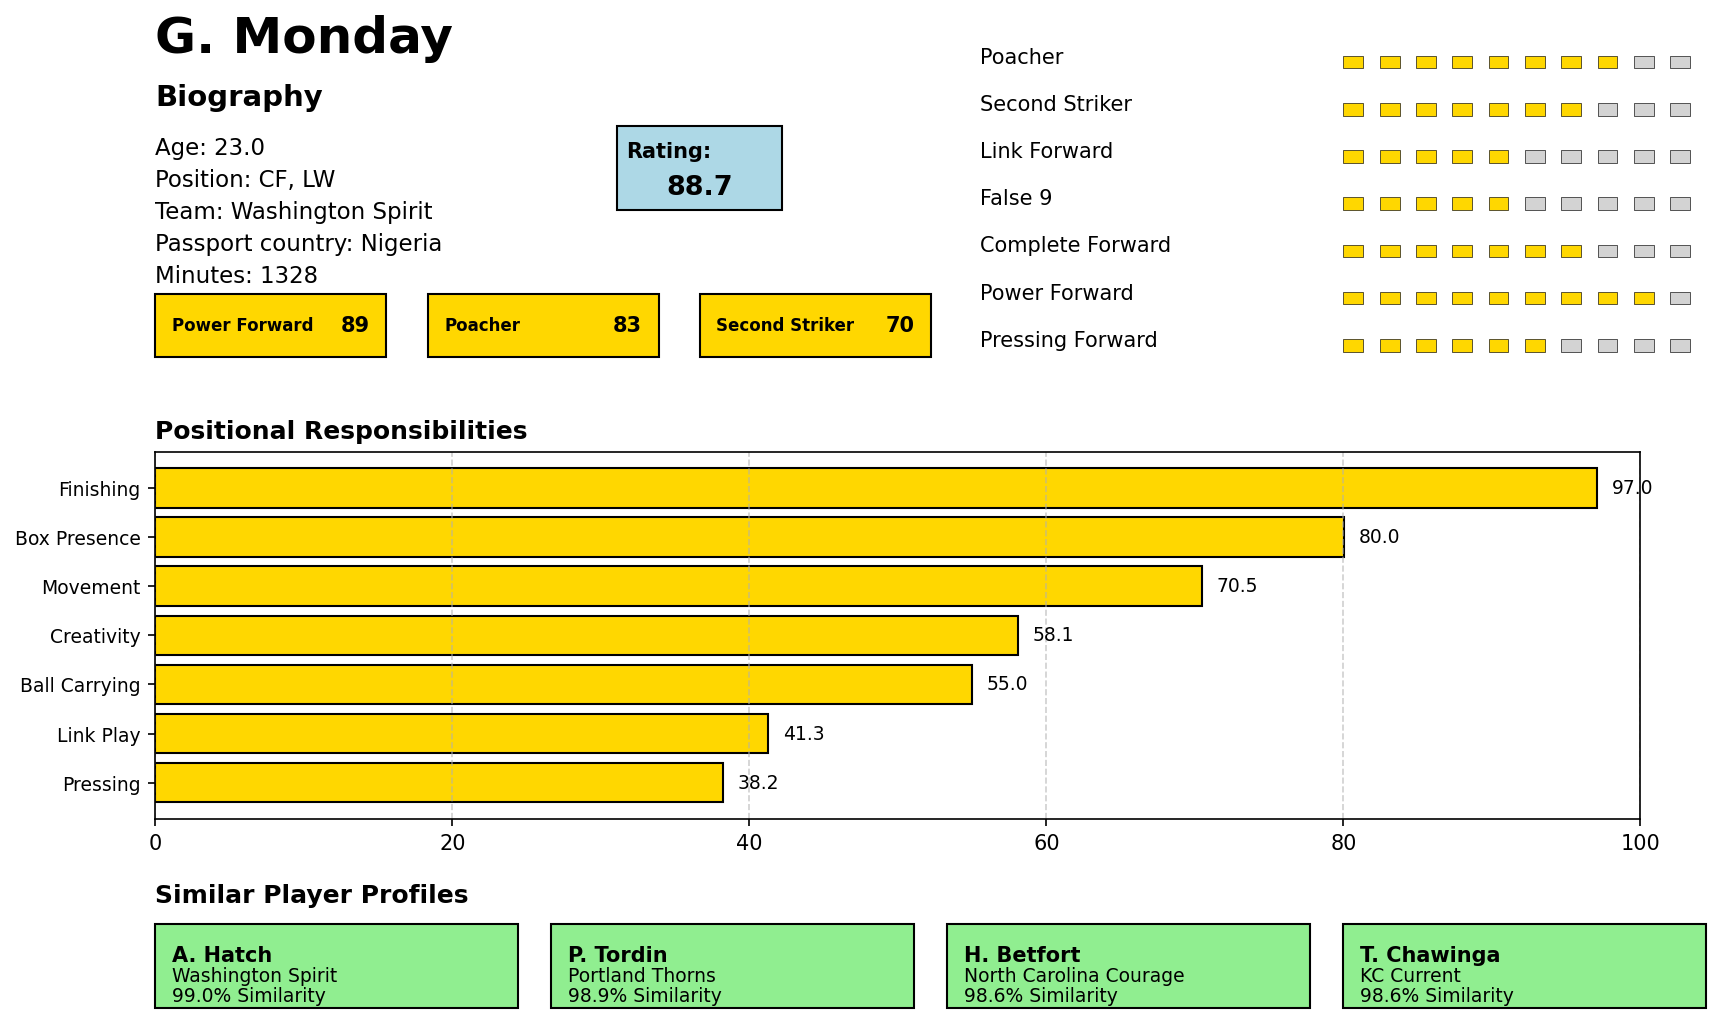

In [ ]:
# ----------------- USER INPUT -----------------

# Enter the player's name exactly as it appears in the data.
player_name = "T. Monday"

# Choose the position group for analysis.
# Valid options are: 'Centre-back', 'Full-back', 'Midfielder', 'Attacking Midfielder', 'Attacker'
position_group = "Centre-back"

# ----------------------------------------------

# Call the function to generate and display the profile
generate_player_profile(player_name, position_group)